# KNN with Gridsearch_Siri Saladi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
bank_df = pd.read_csv( r'bank.csv')
bank_df.head(5)

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                4521 non-null   int64 
 1   job                4521 non-null   object
 2   marital            4521 non-null   object
 3   education          4521 non-null   object
 4   default            4521 non-null   object
 5   balance            4521 non-null   int64 
 6   housing-loan       4521 non-null   object
 7   personal-loan      4521 non-null   object
 8   current-campaign   4521 non-null   int64 
 9   previous-campaign  4521 non-null   int64 
 10  subscribed         4521 non-null   object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


In [4]:
bank_df.subscribed.value_counts()

no     4000
yes     521
Name: subscribed, dtype: int64

In [5]:
from sklearn.utils import resample
bank_subscribed_no = bank_df[bank_df.subscribed == 'no']
bank_subscribed_yes = bank_df[bank_df.subscribed == 'yes']

In [6]:
## In Line 5 Importing resample from *sklearn.utils* package. 
#Separate the case of yes-subscribes and no-subscribes

In [7]:
df_minority_upsampled = resample(bank_subscribed_yes,replace=True,n_samples=2000)
##Upsampled the yes-subscribed cases

In [8]:
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])
# Combined majority class with upsampled minority class

In [9]:
from sklearn.utils import shuffle
new_bank_df = shuffle(new_bank_df)

In [10]:
new_bank_df.subscribed.value_counts()

no     4000
yes    2000
Name: subscribed, dtype: int64

In [11]:
X_features = list( new_bank_df.columns )  # Assigning list of all column names in the DataFrame
X_features.remove( 'subscribed' ) # Remove the response variable from the list
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [12]:
encoded_bank_df = pd.get_dummies( new_bank_df[X_features], drop_first = True )
X = encoded_bank_df
## get_dummies() will convert all the columns with data type as objects

In [13]:
Y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') )
# Encoding the subscribed column and assigning to Y

In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split( X,
Y,
test_size = 0.3,
random_state = 42 )
# Setting random_state a fixed value will guarantee
# that the same sequence of random numbers is generated each time you run the code.

In [15]:
import sklearn as sl
from sklearn.neighbors import KNeighborsClassifier
# Importing the KNN classifier algorithm
knn_clf = KNeighborsClassifier()
# Initializing the classifier

In [16]:
knn_clf.fit( train_X, train_y ) # Fitting the model with the training set

KNeighborsClassifier()

In [17]:
from sklearn import metrics # Importing the metrics


In [18]:
## The method takes the three following parameters
## model: the classification model
## test_X: X features of the test set
## test_y: actual labels of the test set
## Returns
## - ROC Auc Score
## - FPR and TPRs for different threshold values

In [19]:
def draw_roc_curve( model, test_X, test_y ):
    test_results_df = pd.DataFrame( { 'actual': test_y } )
    test_results_df = test_results_df.reset_index() ## Creating and initializing a results DataFrame with actual labels
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) ) # predict the probabilities on the test set
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2] # selecting the probabilities that the test example belongs to class 1
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual,
    test_results_df.chd_1,
    drop_intermediate = False ) # Invoke roc_curve() to return the fpr, tpr and threshold values. threshold values contain values from 0.0 to 1.0
    auc_score = metrics.roc_auc_score( test_results_df.actual, test_results_df.chd_1 ) # Getting the roc auc score by invoking metrics.roc_auc_score method
    plt.figure(figsize=(8, 6)) # Setting the size of the plot
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--') # plotting th diagnoal line from (0,1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) # Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return auc_score, fpr, tpr, thresholds

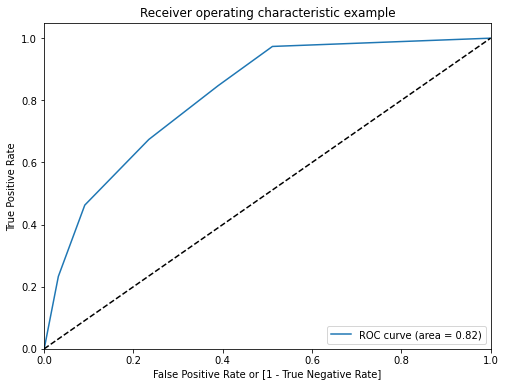

In [20]:
# Invoking draw_roc_curve with the KNN model
_, _, _, _ = draw_roc_curve( knn_clf, test_X, test_y )

In [21]:
from sklearn import metrics ## Importing the metrics. # Defining the matrix to draw the confusion metrix from actual and predicted class labels
def draw_cm( actual, predicted ): # Invoking confusion_matrix from metric package. The matrix will oriented as[1,0] i.e.
# the classes with label 1 will be reprensted the first row and 0 as secondrow
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    sn.heatmap(cm, annot=True, fmt='.2f',
    xticklabels = ["Subscribed", "Not Subscribed"] ,
    yticklabels = ["Subscribed", "Not Subscribed"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    ## Confustion will be plotted as heatmap for better visualization
## The lables are configured to better interpretation from the plot

C:\Users\Siri\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


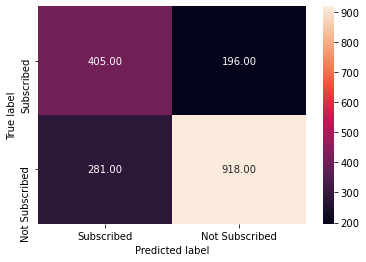

In [22]:
## Predicting on test set
pred_y = knn_clf.predict(test_X)
## Drawing the confusion matrix for KNN model
draw_cm( test_y, pred_y )

In [23]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1199
           1       0.59      0.67      0.63       601

    accuracy                           0.73      1800
   macro avg       0.71      0.72      0.71      1800
weighted avg       0.75      0.73      0.74      1800



# GridSearch for most optimal parameters - KNN

In [24]:
## Importing GridSearchCV
from sklearn.model_selection import GridSearchCV
## Creating a dictionary with hyperparameters and possible values for searching
tuned_parameters = [{'n_neighbors': range(5,10),'metric': ['canberra', 'euclidean', 'minkowski']}]

## Configuring grid search
clf = GridSearchCV(KNeighborsClassifier(),tuned_parameters,cv=10,scoring='roc_auc') # 10 fold CV

## fit the search with training set
clf.fit(train_X, train_y )

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['canberra', 'euclidean', 'minkowski'],
                          'n_neighbors': range(5, 10)}],
             scoring='roc_auc')

In [25]:
clf.best_score_

0.8285897120708545

In [26]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 5}